In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.data import Dataset

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

## Exploratory Data Analysis

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
print(f'Train image shape: {train_images.shape}')
print(f'Test image shape: {test_images.shape}')

Train image shape: (50000, 32, 32, 3)
Test image shape: (10000, 32, 32, 3)


In [5]:
n_labels = len(np.unique(train_labels))
print(f'Number of labels: {n_labels}')

Number of labels: 10


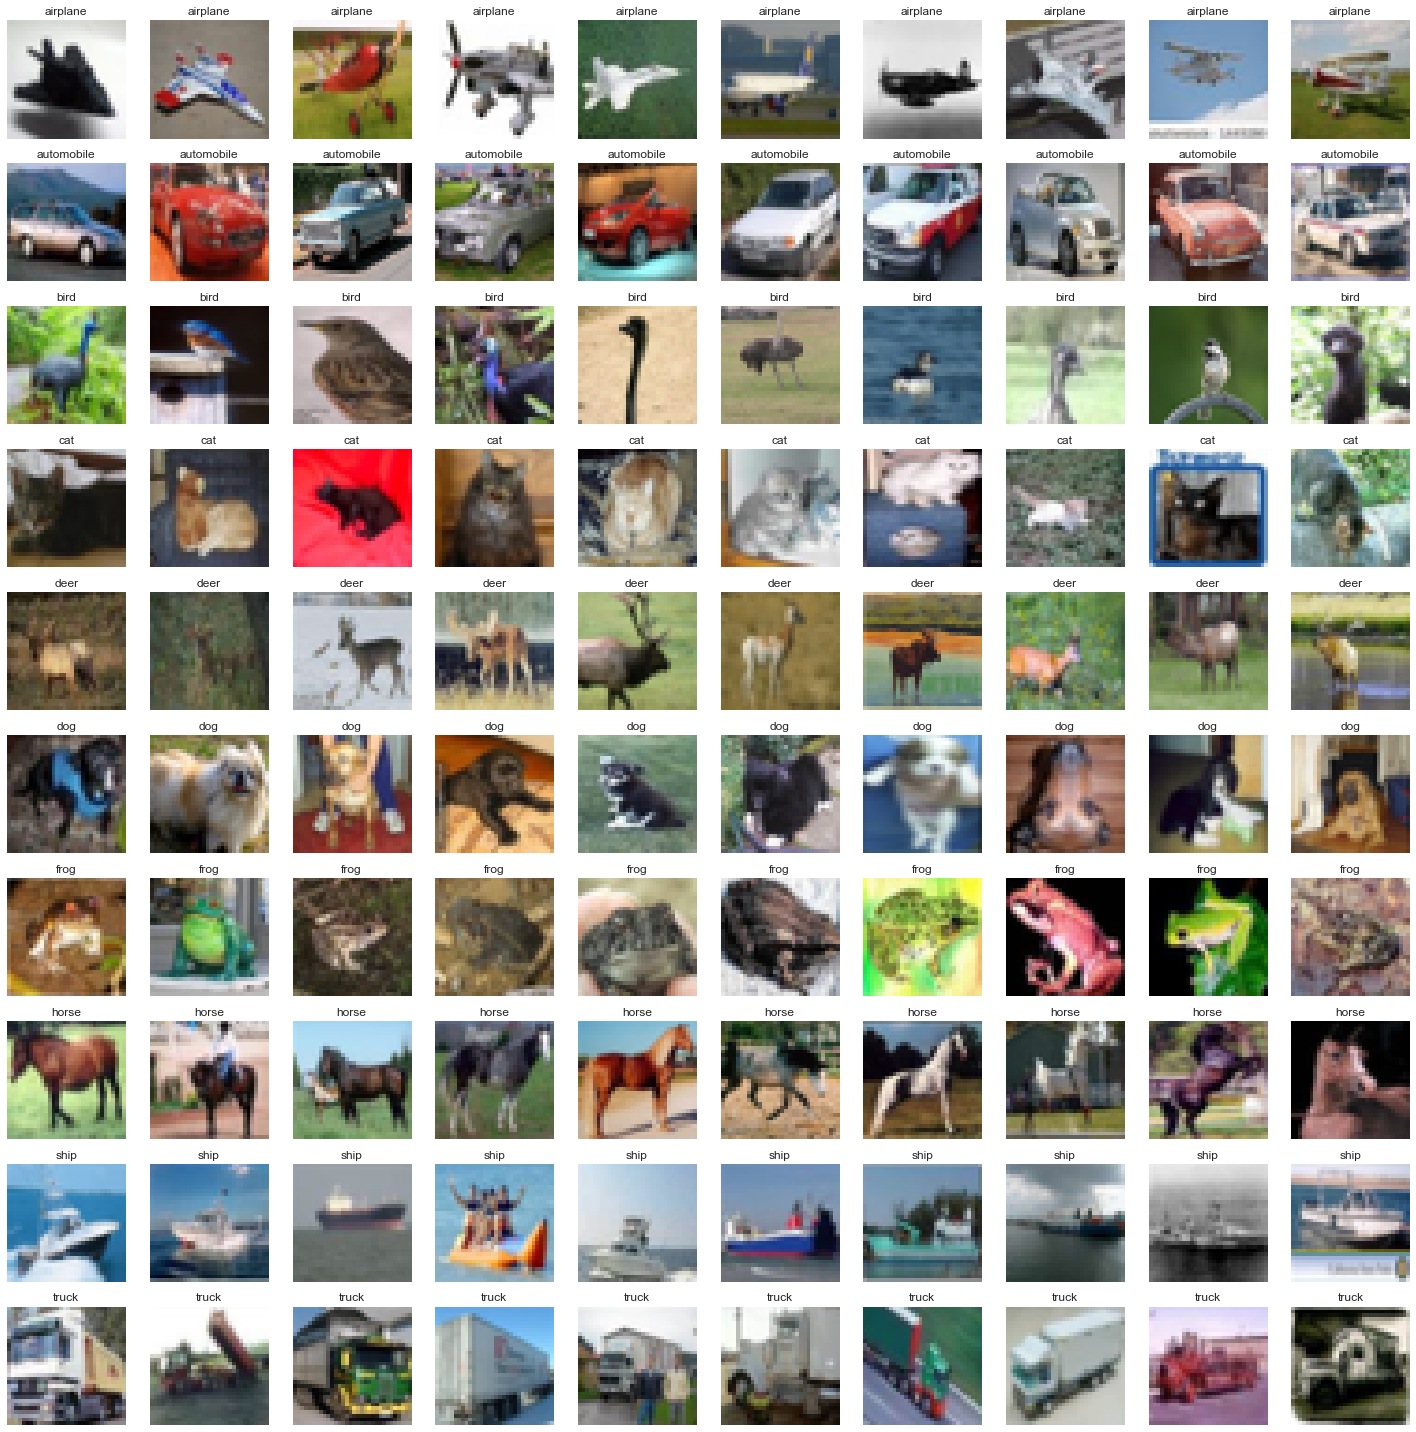

In [6]:
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def display_images(images, labels, n_images=10):
    fig, axes = plt.subplots(nrows=n_labels, ncols=n_images, figsize=(20, 20))
    for i in range(n_images):
        for j in range(n_labels):
            axes[j, i].imshow(images[labels.flatten() == j][i])
            axes[j, i].set_title(label_map[j])
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(train_images, train_labels)

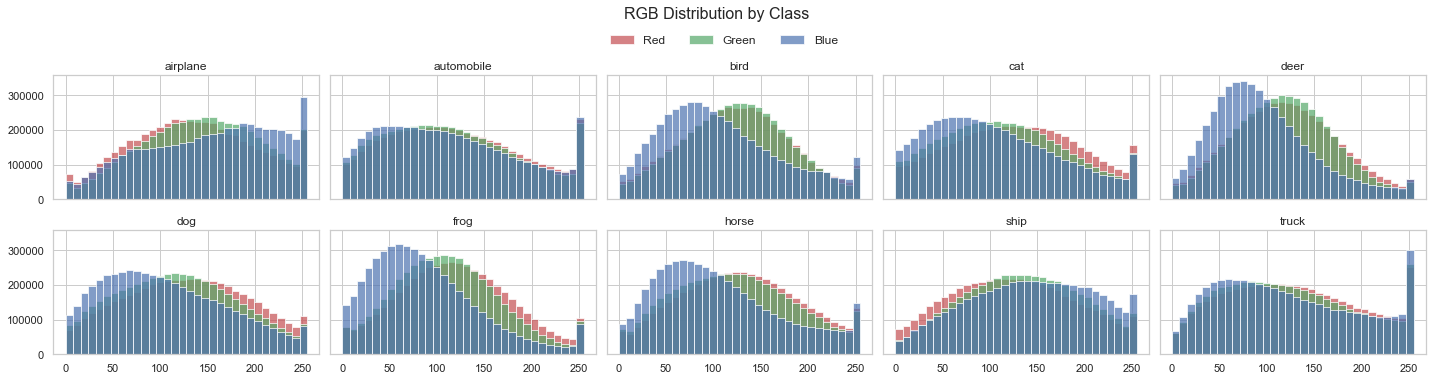

In [7]:
bins = 32

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5), sharex=True, sharey=True)

for i, ax in zip(range(n_labels), axes.flat):
    idx = np.where(train_labels == i)[0]
    ax.hist(train_images[idx, ..., 0].ravel(), bins=bins, color='r', alpha=.7)
    ax.hist(train_images[idx, ..., 1].ravel(), bins=bins, color='g', alpha=.7)
    ax.hist(train_images[idx, ..., 2].ravel(), bins=bins, color='b', alpha=.7)
    ax.set_title(label_map[i])

fig.legend(['Red', 'Green', 'Blue'], loc='upper right', fontsize=12, ncol=3, bbox_to_anchor=(0.592, 1.0), frameon=False)
fig.suptitle('RGB Distribution by Class', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Data Preperation

In [8]:
images = tf.concat([train_images, test_images], axis=0)
labels = tf.concat([train_labels, test_labels], axis=0)

images = tf.cast(images, tf.float32)
# images = (images - 127.5) / 127.5  # normalize images to range [-1, 1] as generator will be using tanh activation
labels = tf.cast(labels, tf.int32)

print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (60000, 32, 32, 3)
Labels shape: (60000, 1)


In [9]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 128

dataset = Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.map(lambda x, y: ((x - 127.5) / 127.5, y))  # normalize images to range [-1, 1] as generator will be using tanh activation

print(dataset.element_spec, type(dataset))

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)) <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [10]:
for batch in dataset.take(1):
    image, label = batch
    print(f'Image shape: {image.shape}')
    print(f'Label shape: {label.shape}')

Image shape: (128, 32, 32, 3)
Label shape: (128, 1)


## Export Dataset

In [11]:
FILE_DIR = 'data/'
FILE_NAME = 'cifar10.tfrecords'

dataset.save(FILE_DIR + FILE_NAME)
print(f'Dataset saved to {FILE_DIR + FILE_NAME}')

Dataset saved to data/cifar10.tfrecords
